# Importing several Python libraries for data manipulation, image processing.

In [87]:
import pandas as pd
import numpy as np
from PIL import Image
from time import sleep
from tqdm.auto import tqdm

from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from collections import OrderedDict
import matplotlib.pyplot as plt

import requests, io

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler

**Setting Paths**

In here we set the paths for "Data Column Headings.csv", "final_dataframe.csv", and set base directories for images and sensor data.

In [76]:
images_path = './Operational Data/Small Data Set/Small set images/'
data_path = './Operational Data/Small Data Set/Small set data/'
headers_path = './Data Column Headings.csv'

df_path = 'data_small.csv'

**Loading Data and Headers**

In [42]:
headers = pd.read_csv(headers_path)
df = pd.read_csv(df_path)

In [43]:
df

,Images,Data,Labels
0,00001.jpg,00001.csv,7
1,00002.jpg,00002.csv,6
2,00003.jpg,00003.csv,7
3,00004.jpg,00004.csv,7
4,00005.jpg,00005.csv,3
...,...,...,...
93,00095.jpg,00095.csv,5
94,00096.jpg,00096.csv,6
95,00097.jpg,00097.csv,6
96,00098.jpg,00098.csv,5


# Analyzing and Visualizing Label Distribution

Creates a bar chart to visually represent the distribution of samples across different classes in the 'Labels' column, focusing on the number of axes in trucks.

In [44]:
label_dist = dict(df['Labels'].value_counts())

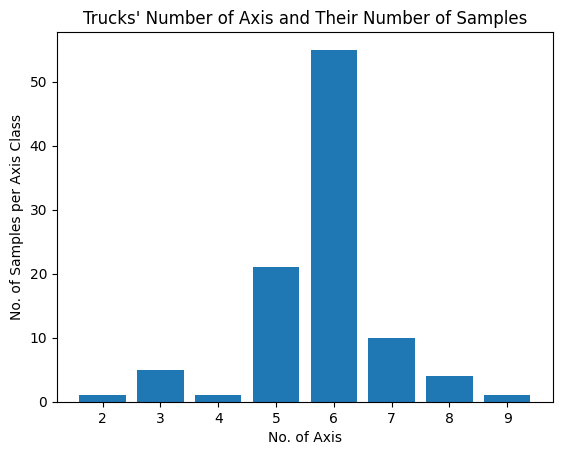

In [45]:
plt.bar(list(label_dist.keys()), list(label_dist.values()))
plt.xlabel("No. of Axis") 
plt.ylabel("No. of Samples per Axis Class") 
plt.title("Trucks' Number of Axis and Their Number of Samples")
plt.show()

In [95]:
def visualize(n):
    # Load dataset
    dataset_sm = df.copy(deep=True)

    # Assuming 'Data' and 'Images' are columns in your dataframe, filter to get record number X
    record_number = n+1 #20
    if record_number <= len(dataset_sm):
        record = dataset_sm.iloc[record_number-1]  # Subtracting 1 because dataframe indexing starts from 0
    else:
        print("Record number exceeds dataset size")
        record = None

    if record is not None:
        # Reading the filtered dataframe without header
        filtered_df_file_path = record['Data']
        axles = record['Labels']
        filtered_df = pd.read_csv(data_path + filtered_df_file_path, header=None)

        # Check if the filtered dataframe is not empty
        if not filtered_df.empty:
            # Assuming you have x and y axis data in your dataframe, update these accordingly
            x_axis, y_axis = 1, 2

            # Create a subplot layout
            fig, ax = plt.subplots(1, 2, figsize=(15, 6))  # 1 row, 2 columns

            # Plot the data
            ax[0].plot(filtered_df[x_axis], filtered_df[y_axis], marker="+", linestyle="-", color="r", markersize="1")
            ax[0].set_title(f'Plot for Record No --> {record_number-1} has {axles + 2} axles')
            ax[0].set_xlabel('Sample Number')
            ax[0].set_ylabel('Sum of Strains Mid-span')
            ax[0].grid(True)

            # Display the image
            image_path = record['Images']  # Get the image path from the filtered row
            # If the image path is a URL
            if image_path.startswith('http'):
                response = requests.get(image_path)
                img = Image.open(io.BytesIO(response.content))
            else:
                img = Image.open(images_path + image_path).convert('RGB')

            ax[1].imshow(img)
            ax[1].axis('off')  # Hide axes for the image

            plt.show()
        else:
            print("No data found for record number {record_number}.")
    else:
        print("Invalid record number.")

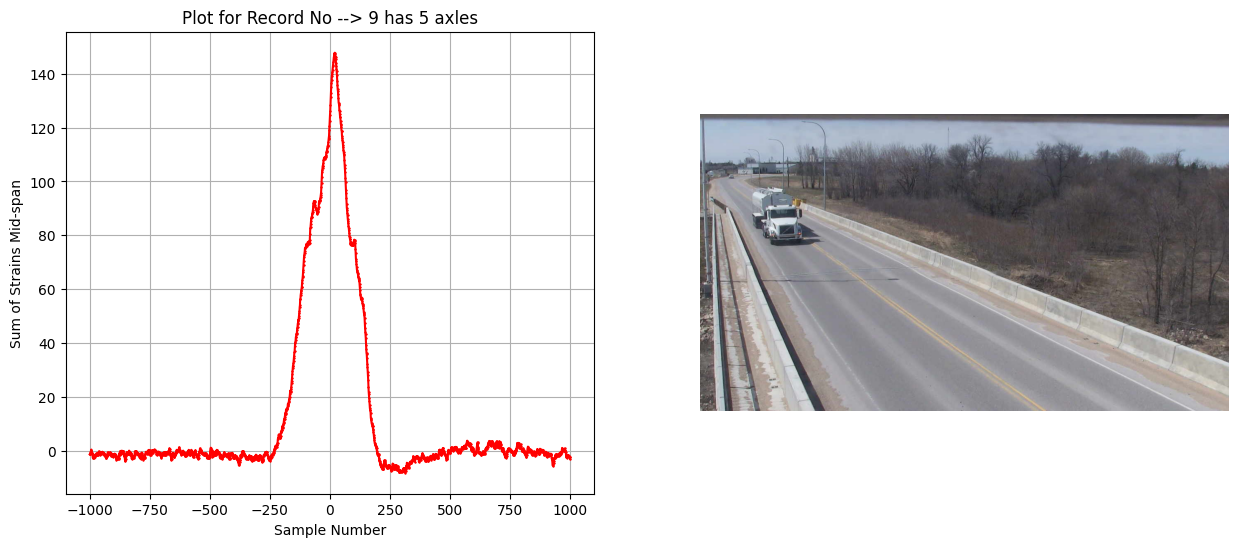

In [96]:
visualize(9)

# Mapping Number of Axis to Their Corresponding Classes

In [47]:
num_classes = np.unique(df['Labels']).shape[0]
df['Labels'] = df['Labels'].apply(lambda x: x - 2)

In [48]:
df

,Images,Data,Labels
0,00001.jpg,00001.csv,5
1,00002.jpg,00002.csv,4
2,00003.jpg,00003.csv,5
3,00004.jpg,00004.csv,5
4,00005.jpg,00005.csv,1
...,...,...,...
93,00095.jpg,00095.csv,3
94,00096.jpg,00096.csv,4
95,00097.jpg,00097.csv,4
96,00098.jpg,00098.csv,3


In [49]:
np.unique(df['Labels'])

array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int64)

# Loading Faster-RCNN and Some Initializations

In [50]:
rcnn = models.detection.fasterrcnn_resnet50_fpn_v2(weights='DEFAULT')
rcnn.eval()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

RESIZE = 448
BATCH_SIZE = 16
SPLIT_PERCENT = 0.75
EMBEDD_DIM = 9995
use_rcnn = False
save_base_model = False
save_rcnn_model = False

COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']

# Image Data Transformation Pipeline

prepare image data for training and inference in models. The transformations include resizing images, applying data augmentation techniques. The normalize transformation adjusts pixel values based on specified means and standard deviations. 

In [51]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

data_transforms = {
    'train':
    transforms.Compose([
        transforms.Resize((RESIZE, RESIZE)),
        # transforms.GaussianBlur((19, 19)),
        # transforms.RandomAffine(0, shear=10, scale=(0.9,1.1)),
        transforms.RandomHorizontalFlip(),
        # transforms.RandomRotation(10),
        # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.ToTensor(),
        normalize
    ]),
    'other':
    transforms.Compose([
        transforms.Resize((RESIZE, RESIZE)),
        # transforms.GaussianBlur((19, 19)),
        transforms.ToTensor(),
        normalize
    ]),
    'rcnn':
    transforms.Compose([
        transforms.Resize((RESIZE, RESIZE)),
        # transforms.GaussianBlur((19, 19)),
        transforms.ToTensor(),
        # normalize
    ]),
    'rcnn_v':
    transforms.Compose([
        transforms.Resize((RESIZE, RESIZE)),
        # transforms.ToTensor(),
        # normalize
    ])
}

# Truck Extraction from Images

The function ***extract_trucks*** is used when loading data to feed to the DataLoader. It approximated the region(s) which the truck is in, picks its relative bounding box, crops the main image, and uses the appropriate transformations to return the image data. 

In [52]:
def extract_trucks(model, img, transform=None):

    model.eval()
    img_rcnn = data_transforms['rcnn'](img)
    img_v = np.array(data_transforms['rcnn_v'](img))
    c, w, h = img_rcnn.shape

    res = model(img_rcnn.reshape((1, c, w, h)))
    bboxes, lbls = res[0]['boxes'].detach(), res[0]['labels']
    bboxes = [np.array(each, dtype=int) for each in bboxes]
    bboxes = np.array(bboxes)

    trucks_bboxs = []

    for i, each_lbl in enumerate(lbls):
        if each_lbl == 8:
            trucks_bboxs.append(bboxes[i])

    if len(trucks_bboxs) > 0:
        max_wh = 0
        max_wh_id = 0
    
        for i, (x, y, a, b) in enumerate(trucks_bboxs):
            w = a - x
            h = b - y
        
            if w + h > max_wh:
                max_wh = w + h
                max_wh_id = i
    
    
        truck = trucks_bboxs[max_wh_id]

        img_crop = img_v[truck[1]: truck[3], truck[0]: truck[2]]
    
    else:
        img_crop = img_v

    if transform:
        img_crop = transform(Image.fromarray(img_crop))

    return img_crop

# Custom Truck Dataset Class

In [75]:
class TruckDataset(Dataset):
    def __init__(self,
                df,
                transform=None,
                shuffle_data=True,
                use_rcnn=True):

        self.df = df
        self.transform = transform
        self.use_rcnn = use_rcnn

        if shuffle_data:
            self.df = self.df.sample(frac=1).reset_index(drop=True)


    def __len__(self) -> int:
        return len(self.df)

    def __getitem__(self, idx) -> tuple:
        image = Image.open(images_path + self.df.iloc[idx, 0]).convert("RGB")
        label = self.df.iloc[idx, 2]
        if self.use_rcnn:
            image = extract_trucks(rcnn, image, self.transform)
        else:
            if self.transform:
                image = self.transform(image)
        
        data = pd.read_csv(data_path +self.df.iloc[idx, 1])
        data.columns = headers.columns
        data = data[['Sum of strains mid span', ' TC1', ' TC2', ' TC3', ' TC4']]
        data = torch.from_numpy(data.values)
        data = data.reshape((-1))
        return image, data, label

# Data Preparation and Loading for Truck Image and Structured Data

In [59]:
tr_dt = TruckDataset(df, transform=data_transforms['train'], use_rcnn=use_rcnn)
ts_dt = TruckDataset(df, transform=data_transforms['other'], use_rcnn=use_rcnn)


dt_size = len(tr_dt)
indices = list(range(dt_size))
split_idx = int(SPLIT_PERCENT * dt_size)

tr_indices, ts_indices = indices[:split_idx], indices[split_idx:]

tr_sampler = SubsetRandomSampler(tr_indices)
ts_sampler = SubsetRandomSampler(ts_indices)

tr_loader = DataLoader(tr_dt, batch_size=BATCH_SIZE, sampler=tr_sampler)
ts_loader = DataLoader(ts_dt, batch_size=BATCH_SIZE, sampler=ts_sampler)

dataloaders = {
    'train': tr_loader,
    'validation': ts_loader
}

In [60]:
X, y, z = next(iter(tr_loader))
X.shape, y.shape, z.shape

(torch.Size([16, 3, 448, 448]), torch.Size([16, 9995]), torch.Size([16]))

In [61]:
train_len = len(tr_indices)
test_len = len(ts_indices)

In [62]:
del tr_dt, ts_dt, tr_sampler, ts_sampler, tr_indices, ts_indices, tr_loader, ts_loader, indices, split_idx, dt_size

# Convolutional Neural Network Architecture for Truck Image Classification

The architecture consists of three main convolutional layers (layer1, layer2, andlayer3), each followed by ReLU activation, batch normalization, max-pooling, and dropout layers.

In [63]:
class TrucksCNN(nn.Module):
    def __init__(self, num_features):
        
        super().__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(num_features, 128, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(4, 4),
            nn.Dropout2d(0.1),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.1)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.1),
            # nn.Conv2d(256, 256, 3, padding=1),
            # nn.ReLU(),
            # nn.BatchNorm2d(256),
            # nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.1)
        )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 512, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.1),
            # nn.Conv2d(512, 512, 3, padding=1),
            # nn.ReLU(),
            # nn.BatchNorm2d(512),
            # nn.MaxPool2d(2, 2),
            # nn.Dropout2d(0.1)
        )
        
        
        # self.fc = nn.Sequential(
        #     nn.Flatten(),
        #     nn.Linear(256 * 3 * 3, 256, True),
        #     nn.BatchNorm1d(256),
        #     nn.Dropout1d(0.1),
        #     nn.Linear(256, 128, True),
        #     nn.BatchNorm1d(128),
        #     nn.Dropout1d(0.1),
        #     nn.Linear(128, 7, True),
        # )


    
    def forward(self, x):

        # print(x.shape)
        x = self.layer1(x)
        # print(x.shape)
        x = self.layer2(x)
        # print(x.shape)
        x = self.layer3(x)
        # print(x.shape)

        return x

# Stacked Attention Network (SAN)

Attention layers help to pay attention to certion regions of the image representaion based on its corresponding sensor data.

In [65]:
class AttentionLayer(nn.Module):
    def __init__(self, dim):
        super().__init__()

        self.representation_dim = dim
        self.fi_lin = nn.Sequential(
            nn.Linear(self.representation_dim, self.representation_dim, bias=True),
            nn.Linear(self.representation_dim, self.representation_dim, bias=True)
        )
        self.vi_lin = nn.Linear(self.representation_dim, self.representation_dim, bias=False)
        self.vq_lin = nn.Linear(self.representation_dim, self.representation_dim, bias=True)
        self.pi_lin = nn.Linear(self.representation_dim, 1, bias=True)


    def forward(self, fi, vq):

        # print('fi\'s shape:', fi.shape)
        fi = fi.view((fi.shape[0], -1, fi.shape[1]))
        vi = F.tanh(self.fi_lin(fi))
        # print('vi\'s shape:', vi.shape)
        vi2 = self.vi_lin(vi)
        # print('vi2\'s shape:', vi2.shape)
        vq2 = self.vq_lin(vq)
        vq2 = vq2.view((vq2.shape[0], 1, -1))
        # print('vq2\'s shape:', vq2.shape)
        ha = F.tanh(vi2 + vq2)
        # print('ha\'s shape:', ha.shape)
        pi = F.softmax(self.pi_lin(ha), dim=1)
        # print('pi\'s shape:', pi.shape)
        v = torch.sum((pi * vi2), dim=1)
        # print('v\'s shape:', v.shape)
        u = v + vq
        # print('u\'s shape:', u.shape)
        return u

# Implementing the Model 

In [66]:
class TruckModel(nn.Module):
    def __init__(self,
                input_representation_shape: int,
                embedd_dim: int,
                num_classes: int,
                num_lstm_layers: int=2,
                ) -> None:
        super().__init__()

        self.txt_encoder = nn.GRU(embedd_dim, input_representation_shape, num_lstm_layers, batch_first=True)

        # self.img_encoder = TrucksCNN(3)
        self.img_encoder = models.resnet18(weights='DEFAULT')
        self.img_encoder = torch.nn.Sequential(OrderedDict([*(list(self.img_encoder.named_children())[:-2])]))
        for param in self.img_encoder.parameters():
            param.requires_grad = False
        # self.img_encoder.layer4[1].conv2.weight.requires_grad = True
        # self.img_encoder.layer4[1].bn2.weight.requires_grad = True
        # self.img_encoder.layer4[1].bn2.bias.requires_grad = True

        self.att1 = AttentionLayer(input_representation_shape)
        self.att2 = AttentionLayer(input_representation_shape)
        self.fc = nn.Linear(input_representation_shape, num_classes)


    def forward(self, vi: torch.Tensor, vq: torch.Tensor) -> torch.Tensor:
        q = self.txt_encoder(vq)[0]
        # print(q.shape)
        i = self.img_encoder(vi)
        u = self.att1(i, q)
        u = self.att2(i, u)
        u = F.softmax(self.fc(u), dim=1)
        return u

In [67]:
def train_model(model, criterion, optimizer, num_epochs=3):
    for epoch in range(num_epochs):
        print('-' * 50)
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            with tqdm(dataloaders[phase], unit='batch', position=0, leave=True) as pbar:
                for img, data, lbl in pbar:

                    pbar.set_description(f"Epoch {epoch+1}")

                    img = img.to(device)
                    data = data.to(device).to(torch.float32)
                    lbl = lbl.to(device)
                    outputs = model(img,  data)
                    loss = criterion(outputs, F.one_hot(lbl, num_classes=num_classes).float())

                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                    _, preds = (torch.max(outputs, 1))
                    running_loss += loss.item()
                    running_corrects += torch.sum(preds == lbl.data)
                    pbar.set_postfix(loss=loss.item() / BATCH_SIZE, accuracy=torch.sum(preds == lbl.data).item() / BATCH_SIZE)
                    sleep(0.1)

            epoch_loss = running_loss / (train_len if phase == 'train' else test_len)
            epoch_acc = running_corrects.double() / (train_len if phase == 'train' else test_len)

            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

    return model

# Evaluation 

The model is evaluated with metrics such as accuracy, precision, recall, f1-score 

In [68]:
def evaluate(model, dataloaders):

    model.eval()
    
    prec_rec_f1 = {'train': [[], [], []], 'validation': [[], [], []]}
    acc = {'train': [], 'validation': []}

    for phase in ['train', 'validation']:
        
        with tqdm(dataloaders[phase], unit='batch', position=0, leave=True) as pbar:
            
            for X, y, z in pbar: 
                X = X.to(device)
                y = y.to(device).to(torch.float32)
                z = z.to(device)
                
                outputs = model(X, y)
                _, preds = (torch.max(outputs, 1))
                
                batch_prec_rec_f1_score = precision_recall_fscore_support(np.array(z.cpu()), np.array(preds.cpu()), average='micro')
                batch_acc = accuracy_score(np.array(z.cpu()), np.array(preds.cpu()))
                
                prec_rec_f1[phase][0].append(batch_prec_rec_f1_score[0])
                prec_rec_f1[phase][1].append(batch_prec_rec_f1_score[1])
                prec_rec_f1[phase][2].append(batch_prec_rec_f1_score[2])
                acc[phase].append(batch_acc)
                
                pbar.set_postfix(prec=batch_prec_rec_f1_score[0],
                                            rec=batch_prec_rec_f1_score[1],
                                            f1=batch_prec_rec_f1_score[2],
                                            acc=batch_acc)


        prec_rec_f1[phase][0] = np.mean(np.array(prec_rec_f1[phase][0]))
        prec_rec_f1[phase][1] = np.mean(np.array(prec_rec_f1[phase][1]))
        prec_rec_f1[phase][2] = np.mean(np.array(prec_rec_f1[phase][2]))
        acc[phase] = np.mean(np.array(acc[phase]))


    print(f'Precision on train set: {prec_rec_f1["train"][0]}')
    print(f'Precision on validation set: {prec_rec_f1["validation"][0]}')
    print()
    print(f'Recall on train set: {prec_rec_f1["train"][1]}')
    print(f'Recall on validation set: {prec_rec_f1["validation"][1]}')
    print()
    print(f'F1-Score on train set: {prec_rec_f1["train"][2]}')
    print(f'F1-Score on validation set: {prec_rec_f1["validation"][2]}')
    print()
    print(f'Accuracy on train set: {acc["train"]}')
    print(f'Accuracy on validation set: {acc["validation"]}')

In [69]:
torch.manual_seed(42)
model = TruckModel(input_representation_shape=512, embedd_dim=EMBEDD_DIM, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters())

model_trained = train_model(model, criterion, optimizer, num_epochs=10)

--------------------------------------------------
Epoch 1/10
----------


  0%|          | 0/5 [00:00<?, ?batch/s]

train loss: 0.1265, acc: 0.3836


  0%|          | 0/2 [00:00<?, ?batch/s]

validation loss: 0.1411, acc: 0.5600
--------------------------------------------------
Epoch 2/10
----------


  0%|          | 0/5 [00:00<?, ?batch/s]

train loss: 0.1199, acc: 0.5205


  0%|          | 0/2 [00:00<?, ?batch/s]

validation loss: 0.1372, acc: 0.5600
--------------------------------------------------
Epoch 3/10
----------


  0%|          | 0/5 [00:00<?, ?batch/s]

train loss: 0.1179, acc: 0.5205


  0%|          | 0/2 [00:00<?, ?batch/s]

validation loss: 0.1353, acc: 0.5600
--------------------------------------------------
Epoch 4/10
----------


  0%|          | 0/5 [00:00<?, ?batch/s]

train loss: 0.1192, acc: 0.5205


  0%|          | 0/2 [00:00<?, ?batch/s]

validation loss: 0.1372, acc: 0.5600
--------------------------------------------------
Epoch 5/10
----------


  0%|          | 0/5 [00:00<?, ?batch/s]

train loss: 0.1186, acc: 0.5205


  0%|          | 0/2 [00:00<?, ?batch/s]

validation loss: 0.1353, acc: 0.5600
--------------------------------------------------
Epoch 6/10
----------


  0%|          | 0/5 [00:00<?, ?batch/s]

train loss: 0.1199, acc: 0.5205


  0%|          | 0/2 [00:00<?, ?batch/s]

validation loss: 0.1372, acc: 0.5600
--------------------------------------------------
Epoch 7/10
----------


  0%|          | 0/5 [00:00<?, ?batch/s]

train loss: 0.1199, acc: 0.5205


  0%|          | 0/2 [00:00<?, ?batch/s]

validation loss: 0.1411, acc: 0.5600
--------------------------------------------------
Epoch 8/10
----------


  0%|          | 0/5 [00:00<?, ?batch/s]

train loss: 0.1206, acc: 0.5205


  0%|          | 0/2 [00:00<?, ?batch/s]

validation loss: 0.1372, acc: 0.5600
--------------------------------------------------
Epoch 9/10
----------


  0%|          | 0/5 [00:00<?, ?batch/s]

train loss: 0.1206, acc: 0.5205


  0%|          | 0/2 [00:00<?, ?batch/s]

validation loss: 0.1353, acc: 0.5600
--------------------------------------------------
Epoch 10/10
----------


  0%|          | 0/5 [00:00<?, ?batch/s]

train loss: 0.1206, acc: 0.5205


  0%|          | 0/2 [00:00<?, ?batch/s]

validation loss: 0.1411, acc: 0.5600


# Results

The trained model achieved 51.38% accuracy on training set and 55.90% on validation set 

In [70]:
evaluate(model_trained, dataloaders)

  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Precision on train set: 0.513888888888889
Precision on validation set: 0.5590277777777778

Recall on train set: 0.513888888888889
Recall on validation set: 0.5590277777777778

F1-Score on train set: 0.513888888888889
F1-Score on validation set: 0.5590277777777778

Accuracy on train set: 0.513888888888889
Accuracy on validation set: 0.5590277777777778


In [71]:
if use_rcnn:
    PATH = './models/model_base.pth'
else:
    model_rcnn_path = './models/model_rcnn.pth'

torch.save(model_trained, PATH)

# Loading Previous Models

In [72]:
model_base_path = './models/model_base.pth'
rcnn_path = './models/model_rcnn.pth'

base = torch.load(model_base_path)
rcnn = torch.load(rcnn_path)

# Loaded Models' Results

The basic model without Faster-RCNN transformation, achieved 54.30% and 53.47% accuracy on training and validation set.
The  model with Faster-RCNN transformation, achieved 53.33% and 58.33% accuracy on training and validation set.  

In [73]:
evaluate(base, dataloaders)

  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Precision on train set: 0.5430555555555555
Precision on validation set: 0.5347222222222222

Recall on train set: 0.5430555555555555
Recall on validation set: 0.5347222222222222

F1-Score on train set: 0.5430555555555555
F1-Score on validation set: 0.5347222222222222

Accuracy on train set: 0.5430555555555555
Accuracy on validation set: 0.5347222222222222


In [74]:
evaluate(rcnn, dataloaders)

  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Precision on train set: 0.5333333333333333
Precision on validation set: 0.5833333333333333

Recall on train set: 0.5333333333333333
Recall on validation set: 0.5833333333333333

F1-Score on train set: 0.5333333333333333
F1-Score on validation set: 0.5833333333333333

Accuracy on train set: 0.5333333333333333
Accuracy on validation set: 0.5833333333333333
